In [ ]:
#Valentina Malagòn, Alejandra Ocampo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import linprog
import cvxopt as cvx
import cvxpy as cp
from sklearn.linear_model import LinearRegression
from scipy import stats
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Punto 1

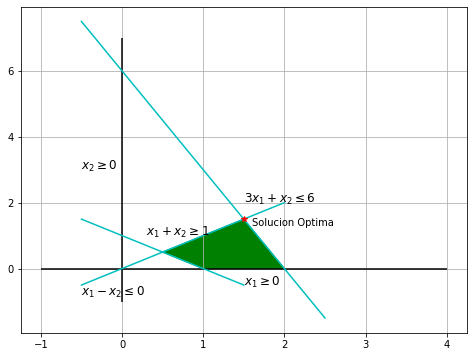

In [ ]:
from matplotlib.patches import Polygon
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()

#Dibujo de las lineas de resticcion 
ax.hlines(0, -1, 4)
ax.vlines(0, -1, 7)
ax.plot(np.linspace(-0.5, 1.5, 100), 1-1*np.linspace(-0.5, 1.5, 100), color="c")
ax.plot(np.linspace(-0.5, 2.5, 100), 6-3*np.linspace(-0.5, 2.5, 100), color="c")
ax.plot(np.linspace(-0.5, 2, 100), 0+1*np.linspace(-0.5, 2, 100), color="c")
ax.text(0.3, 1, "$x_1 + x_2 \geq 1$", size=12)
ax.text(1.5, 2, "$3 x_1 + x_2 \leq 6$", size=12)
ax.text(-0.5, -0.8, "$x_1 - x_2 \leq 0$", size=12)
ax.text(-0.5, 3, "$x_2 \geq 0$", size=12)
ax.text(1.5, -0.5, "$x_1 \geq 0$", size=12)

#Colorear la figura que seria la region factible 
feasible_set = Polygon(np.array([[0.5, 0.5], 
                                 [1.5, 1.5], 
                                 [2, 0], 
                                 [1, 0]]), 
                       color="green")
ax.add_patch(feasible_set)

#Punto de solución óptima
ax.plot(1.5, 1.5, "*", color="red")
ax.text(1.6, 1.3, "Solucion Optima", size=10);

Teniendo en cuenta que los problemas de programacion lineal (LP) lo que buscan es encontrar el valor optimo de una funcion,en el ejercicio que se desarollo anteriormente se busco optimizar a raiz de maximizar el valor de X y de X2

Despues de graficar las restricciones se encuentra la figura verde que representa la region factible del problema en el cuadrante 1. Por lo tanto, nos quedamos con una solucion optima indicada en el punto mas alto de la figura. Donde X y X2 tomaran un valor maximo de aproximadamente 1,5 cada variable.  

# Punto 2

In [ ]:
#Resolucion del problema con linprog
c = np.array([0.1,0.15,0.16,0.08])
A = np.array([[1,1,1,1]])
b = np.array([80])

D = np.array([[0.5,0.3,0.25,0.6],
              [0.3,0.1,0.4,0.2],
              [0.2,0.6,0.35,0.2]])
d = np.array([28,24,12])

resultado = linprog(-c,A_ub=-D,b_ub=-d,A_eq=A,b_eq=b, method='simplex')
resultado

     con: array([0.])
     fun: -10.989473684210527
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([-3.55271368e-15, -3.55271368e-15,  1.60000000e+01])
  status: 0
 success: True
       x: array([ 0.        , 12.63157895, 46.31578947, 21.05263158])

El problema que se desarrollo anteiormente es un problema de inversion, con varias opciones para lograr maximizar la rentabilidad bajo una resticcion presupuestaria de 80 millones y con inversiones minimas en ciertos fondos. Ahora bien, con respecto a los resultados se puede interpretar que para el primer fondo tiene una asignacion de inversion de 0, para el segundo fondo es de 12,6 millones, para el tercero es de 46,3 millones y finalmente para el cuarto fondo es de 21 millones. Todo esto con una ganancia maximizada de 10,98 millones 

In [ ]:
# #Solucion del problema en cvx 
n = 4 #4 variables
x = cp.Variable(n)
c = np.array([0.1,0.15,0.16,0.08])
A = np.array([[1,1,1,1]])
b = np.array([80])

D = np.array([[0.5,0.3,0.25,0.6],
              [0.3,0.1,0.4,0.2],
              [0.2,0.6,0.35,0.2]])
d = np.array([28,24,12])

objective = cp.Maximize(c.T @ x ) #El @ es para multiplicar matrices 
constraints = [D @ x >= d, A @ x  == b,  x>=0]#<> es de la funcion de desigualdad original 
prob = cp.Problem(objective, constraints)

#El objetivo optimo 
result = prob.solve()
# La solucion optima 
sol=round(pd.DataFrame(x.value),4)
sol

,0
0,0.0000
1,12.6316
2,46.3158
3,21.0526


# Punto 3

In [ ]:
#Tiene 14 elementos, A=matriz de 14x14 b=igual a lo que la empresa necesita/produce c=funcion objetivo con 14 elementos 
b = np.array([150, 100, -200, 200, -50, -300])
c = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1]) #Función objetivo
rx = np.array([1.01])  #tasa del crédito
ry = np.array([1.02]) #Tasa del bono inicia mes 4!!!
rz = np.array([1.003]) #Tasa excedente
A = np.array([[1,0,0,0,0, 1,0,0, -1,0,0,0,0,0],
              [-rx,1,0,0,0, 0,1,0, rz,-1,0,0,0,0],
              [0,-rx,1,0,0, 0,0,1, 0,rz,-1,0,0,0],
              [0,0,-rx,1,0, -ry,0,0, 0,0,rz,-1,0,0],
              [0,0,0,-rx,1, 0,-ry,0, 0,0,0,rz,-1,0],
              [0,0,0,0,-rx, 0,0,-ry, 0,0,0,0,rz,-1]])

#Solución con cvxpy
n = len(c) # # de elementos que requiere el vector c
x = cp.Variable(n) #Mismo tamaño de c porque se debe operar x con c

objective = cp.Maximize(c.T @ x )
constraints = [A @ x == b, x>=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
sol = round(pd.DataFrame(x.value),4)
sol

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


,0
0,0.0000
1,42.6867
2,0.0000
3,0.0000
4,8.4595
5,150.0000
6,57.3133
7,195.0578
8,0.0000
9,0.0000


In [ ]:
#Resultado en linprog 
resultado=linprog(-c,A_eq=A,b_eq=b, method="simplex")
resultado 

     con: array([ 0.00000000e+00,  1.42108547e-14, -2.84217094e-14,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
     fun: -92.4969491525423
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([  0.        ,  50.98039216,   0.        ,   0.        ,
         0.        , 150.        ,  49.01960784, 203.43436358,
         0.        ,   0.        , 351.9441675 ,   0.        ,
         0.        ,  92.49694915])

En estev tercer ejercicio se tiene un problema de maximizacion de recursos, al fonal del ejerccio se llega por los metodos al mismo valor (92.496) sin embargo, las soluciones son diferentes. Esto se debe a que hay mas de una manera de llegar al mismo valor resultado. 

# Punto 4

In [ ]:
fechai = "2015-12-01"
fechaf = "2020-12-31"
periodicidad = "1Mo"
activos = ["AAL"]
p_ejercicio = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
r_ejercicio = np.log(p_ejercicio/p_ejercicio.shift(1)).dropna()

indice = yf.download("^GSPC",start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
r_indice = np.log(indice/indice.shift(1)).dropna()

indice2 = yf.download("USO",start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
r_indice2 = np.log(indice2/indice2.shift(1)).dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
slope, intercept, r, p, std_err = stats.linregress(r_indice, r_ejercicio)
def linestim(x):
  return intercept + slope * x

model = list(map(linestim, r_indice))

In [ ]:
lm = LinearRegression()
model = lm.fit(pd.DataFrame(r_indice), pd.DataFrame(r_ejercicio))
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [-0.03581504]
betas = [[1.98261969]]


In [ ]:
slope, intercept, r, p, std_err = stats.linregress(r_indice2, r_ejercicio)
def linestim(x):
  return intercept + slope * x

model = list(map(linestim, r_indice2))

In [ ]:
lm = LinearRegression()
model = lm.fit(pd.DataFrame(r_indice2), pd.DataFrame(r_ejercicio))
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [-0.01045441]
betas = [[0.32148662]]


In [ ]:
t = len(r_indice)
unos = pd.DataFrame(np.repeat(1,t))
r_indice3 = pd.DataFrame(r_indice)
r_indice4=pd.DataFrame(r_indice2)
r_ejercicio2 = pd.DataFrame(r_ejercicio)

variables = np.concatenate((unos,r_indice3,r_indice4),1)
X = variables.T @ variables

Xy = variables.T @ r_ejercicio2

Sol= np.linalg.solve(X,Xy)
Sol

array([[-0.0326005 ],
       [ 1.82444476],
       [ 0.09854343]])

Para el punto 4, hemos elegido el activo de American Airlines Inc (AAL), compañia que se basa en el transporte aereo, con la cual vamos a demostrar 

**β̂ = Q
−1b = (X
TX)
−1XTy**

Para esto se han elegido dos factores (variables) que influyen en la variabilidad del activo, para eso tenemos en primer lugar el indice  Standar & Poor´s 500 (GSPC) y el commoditie del United State Oil Fund (USO).

En primer lugar se ha hecho una estimacion lineal por aparte entre cada variable y el indice, donde hemos encontrado el aplha y el beta del modelo, donde el alpha nos va indicar el rendimiento segun el indice o factor, mientras que el beta va demostrar el riesgo del activo ademas de la correlacion del comportamiento del activo en el mercado y el indice estudiado.

Segun lo anterior, en los modelos que hemos encontrado por separado podemos ver que en el mercado la correlacion de AAL y GSPC es positivo, es decir que el activo es agresivo (que varia bastante si el mercado varia) en este caso se moveria un 1.98 puntos porcentuales, mientras que en la correlacion en el mercado de AAL y USO indica que solo varia en 0.32 puntos porcentuales, por lo que el activo en este mercado no seria agresivo. Por otro lado tenemos los aplhas que en los dos mercados es negativo, lo que nos indica que el rendimiento de la accion fue menor que la de los mercados (segun cada indice) para GSPC un -0,03 y para USO un -0,01.

Finalmente, se realiza la estimacion para el mercado que tiene en cuenta los dos factores y se resuleve segun la estimacion por MCO, donde nos indica que el activo de AAL en el mercado segun el indice GSPC y USO tiene un rendimiento menor a este, adicionalmente que va tener una variabilidad de 1.8 puntos respecto a GSPC y de 0.09 respecto a USO.

Con lo anterior podemos concluir que American Airlines es una compañia que al pertenecer al indice de Standar & Poor´s tiene gran correlacion con esta, mientras que el USO al ser el petroleo y de este sacar la gasolina que necesitan los aviones tambien estan correlacionados.


# Punto 5

In [ ]:
b = np.array([100, 200, 800, 100, 800, 1200])
c = np.array([109, 94.8, 99.5, 93.1, 97.2, 92.9, 110, 104, 102, 95.2, 0, 0, 0, 0, 0, 0])
A = np.array([[10, 7, 8, 6, 7, 5, 10, 8,7,100, -1, 0, 0, 0, 0, 0],
              [10, 7, 8, 6, 7, 5, 10, 8, 7, 0, 1, -1, 0, 0, 0, 0],
              [10, 7, 8, 6, 7, 5, 110,108,0,0, 0, 1, -1, 0, 0, 0],
              [10, 7, 8, 6, 7, 105, 0, 0, 0,0, 0, 0, 1, -1, 0, 0],
              [10, 7, 8, 106, 107, 0, 0,0,0,0, 0, 0, 0, 1, -1, 0],
              [110, 107, 108, 0, 0, 0,0,0,0,0, 0, 0, 0, 0, 1, -1]])


#Solución con cvxpy
n = len(c) # # de elementos que requiere el vector c
x = cp.Variable(n) #Mismo tamaño de c porque se debe operar x con c

objective = cp.Minimize(c.T @ x )
constraints = [A @ x >= b, x>=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
sol = round(pd.DataFrame(x.value),4)
sol

,0
0,0.0000
1,11.2150
2,0.0000
3,6.6338
4,0.0000
5,0.0000
6,0.0000
7,6.0087
8,-0.0000
9,0.0000


Para este ejercicio se busca minimizar el costo del portafolio de bonos cuyos flujos de efectivo serán suficientes
para cubrir los requerimientos de efectivo del fondo. Por lo tanto se plantean 3 matrices, la matriz c con los requerimientos, la matrix b con los precios actuales y la matriz A que muestra los bonos del gobierno con
los flujos de efectivo donde se tiene en cuenta los exedentes de efectivo que pueden transferirse de un año a otro, sin ningun costo adicional. 
En este sentido, se plantea el problema en cvx y nos arroja los resultados del portafolio menos costoso que serian las x, y en este caso son las primeras 10 filas (contando el 0) , las otras 6 serian el residuo entre el saldo a favor que queda menos el requerimiento, es decir si en el año 1 hay un requerimiento de 100 pero el saldo a favor es de 166 por eso el resultado de la fila es 66